In [83]:
# %% Import Modules and Data
import galsim
import matplotlib.pyplot as plt  # noqa: F401
import numpy as np
import pickle
from sf_tools.image.shape import Ellipticity
import math
import copy
from scipy.stats import linregress as lin
import ngmix
%matplotlib inline

In [102]:
# Load T-RECS Catalogue
DIR_nm = '/home/tripathi/Example/'
with open(DIR_nm + "/catalog.pkl", "rb") as fh:
    catalog = pickle.load(fh)

# Load Galaxy Parameters
e1 = catalog["e1"].values
e2 = catalog["e2"].values
flux_all = catalog["I1400"].values  # Flux density at 1400 MHz (in Janskys)
size_all = catalog["size"].values  # angular size (in arcsec)
del catalog

print(f"Mean flux of galaxies= {np.mean(flux_all)*(10**3):.02f} mJ")
print(f"Mean size of galaxies= {np.mean(flux_all):.03f} arcsec")

Mean flux of galaxies= 12.40 mJ
Mean size of galaxies= 0.012 arcsec


In [85]:
# GalSim Parameters
Npix = 128  # Size of image
FFTBIGSIZE = 81488  # Max size of support for Galsim (Caching the FFT)
big_fft_params = galsim.GSParams(maximum_fft_size=FFTBIGSIZE)
scale = 0.07166589  # Calculated using RASCIL (in arcsec/pix)

# Create Stamp Image
stampimage = galsim.ImageF(Npix, Npix, scale=scale)
b = galsim.BoundsI(1, Npix, 1, Npix)
stamp = stampimage[b]

In [86]:
# Simulate Galaxies
ngals = 3000
np.random.seed(2004)   # Seed for reproducitbility
source_indices = np.random.randint(low=0, high=len(e1), size=ngals)

# Dictionary to store galaxy images
dataset = {}
dataset["ellipticity"] = np.array([e1[source_indices], e2[source_indices]]).T
dataset["flux"] = flux_all[source_indices]

gal_arr_all = []
for ind in source_indices:
    flux = flux_all[ind]
    size = size_all[ind]
    e1gal = e1[ind]
    e2gal = e2[ind]

    # Galaxy Profile
    gauss_gal = galsim.Gaussian(fwhm=size, flux=flux)
    gal = galsim.Exponential(
        half_light_radius=gauss_gal.half_light_radius,
        flux=flux,
        gsparams=big_fft_params,
    )

    # Shear Galaxy
    e = galsim.Shear(g1=e1gal, g2=e2gal)
    gal_sheared = gal.shear(e)
    gal_sheared = gal_sheared.drawImage(stamp, scale=scale)
    gal_arr = gal_sheared.array
    gal_arr_all = [*gal_arr_all, copy.deepcopy(gal_arr)]

dataset["gal_arrs"] = np.array(gal_arr_all)


# Choose whether to save data
save_data = False
if save_data:
    with open(DIR_nm + "/simulated_galaxy_dict.pkl", "rb") as fh:
        pickle.dump(dataset, fh)

In [87]:
#%% Measure Ellipticity using GalSim.HSM & sf_tools

# Lists to store measurements
e_meas_hsm = []
e_meas_sf = []
# Track Objects that can't be measured using HSM
bad_hsm = np.zeros(len(dataset["gal_arrs"]))

for i,im in enumerate(dataset["gal_arrs"]):
    # HSM Measurement
    image_galsim = galsim.Image(im)
    shape = galsim.hsm.FindAdaptiveMom(image_galsim, strict=False)
    hsm_meas = np.array((shape.observed_shape.g1, shape.observed_shape.g2))
    e_meas_hsm = [*e_meas_hsm, hsm_meas]
    # Check whether HSM was able to estikmate moments
    if shape.moments_status != 0:
        bad_hsm[i] = 1

    # Sf_tools Measurement
    sf_meas = Ellipticity(im).e
    # Convert to Correct Definition
    s = galsim.Shear(e1=sf_meas[0], e2=sf_meas[1])
    sf_meas_1 = np.array(
        [
            math.copysign(s.g1, hsm_meas[0]),                 # This is done because the ellipticity comp
            math.copysign(s.g2, hsm_meas[1]),                 # from sf_tools are always positive
        ]                                                     # Not sure why it is like this
    )
    e_meas_sf = [*e_meas_sf, sf_meas_1]

e_meas_hsm = np.array(e_meas_hsm)
e_meas_sf = np.array(e_meas_sf)
bad_hsm=np.array(bad_hsm)
print(f"No of objects not resolved by HSM:  {int(np.sum(bad_hsm))}/{ngals}")

No of objects not resolved by HSM:  124/3000


In [88]:
#%% Function for plotting measurements
def plot_ellipticities(
    epred, etrue, fix_lim=False, colors=["blue", "orange"], title=None, bad_index=None
):
    """Convenient Function to plot ellipticities

    Args:
        epred (arr): Measured ELlipticity
        etrue (arr): True Ellipticity
        fix_lim (bool, optional): Whether to fix_limits of plot. Defaults to False.
        colors (list, optional): Colors for the two ellipticty comp. Defaults to ["blue", "orange"].
        title: Title for the plot
        bad_index: Indices to not use for plot. Defaults to None
    Returns:
        plot
    """

    assert (
        epred.shape == etrue.shape
    ), "Measurement array should be of same shape as true array"
    if bad_index is not None:
        epred = epred[~bad_index.astype(bool)]
        etrue = etrue[~bad_index.astype(bool)]

    delta = epred - etrue

    def get_label(epred, etrue, i):
        delta = epred - etrue
        res = lin(etrue[:, i], delta[:, i])
        cap = r"$10^{4}\hat{m}_1$,$10^{4}\hat{c}_1$" if i == 0 else r"$10^{4}\hat{m}_2$,$10^{4}\hat{c}_2$"
        label = (
            # rf"$\Delta\epsilon_{i+1}$"+
            "{"
            + cap
            + "}="
            + " {"
            + rf"{res.slope*1e4:.2f}$\pm${res.stderr*1e4:.2f}"
            + rf", {res.intercept*1e4:.2f}$\pm${res.intercept_stderr*1e4:.2f}"
            + "}"
        )
        return label

    fig = plt.figure()
    ax = fig.add_subplot()
    for i in [0, 1]:
        ax.scatter(
            etrue[:, i],
            delta[:, i],
            label=get_label(epred, etrue, i),
            s=0.7,
            alpha=0.7,
            color=colors[i],
        )

    lim = np.max(np.abs(epred - etrue))
    if (lim < 0.2) or fix_lim:
        lim = 0.05
    ax.set(
        xlabel=r"$\epsilon^{\text{true}}$",
        ylabel=r"$\epsilon^{\text{meas}}-\epsilon^{\text{true}}$",
        xlim=(-1, 1),
        ylim=(-lim, lim),
    )

    if title:
        ax.set_title(title)

    ax.axhline(0, color="black", linewidth=0.7, linestyle="--")
    lgnd = ax.legend()
    for handle in lgnd.legend_handles:
        handle._sizes = [15]
    fig.tight_layout()
    plt.show()


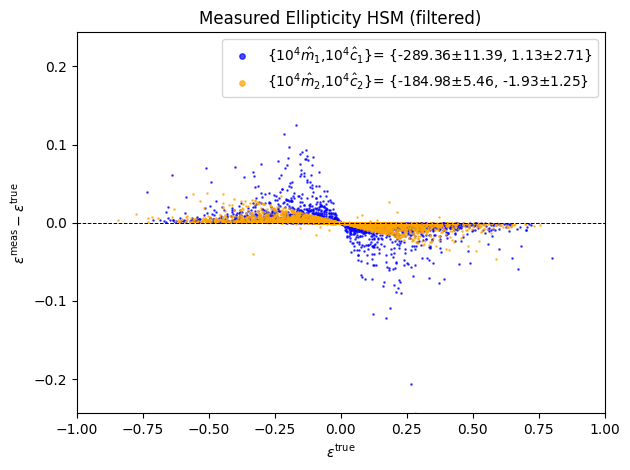

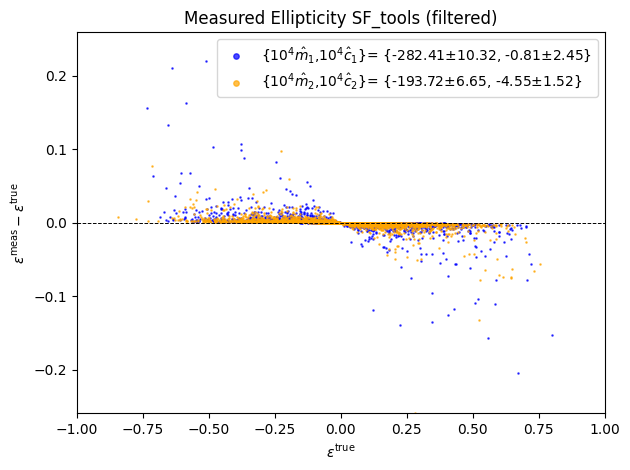

In [89]:
# Plot results
#plot_ellipticities(e_meas_hsm,dataset["ellipticity"],title="Measured Ellipticity HSM")
#plot_ellipticities(e_meas_sf,dataset["ellipticity"],title="Measured Ellipticity SF_tools")
plot_ellipticities(e_meas_hsm,dataset["ellipticity"],title="Measured Ellipticity HSM (filtered)",bad_index=bad_hsm)
plot_ellipticities(e_meas_sf,dataset["ellipticity"],title="Measured Ellipticity SF_tools (filtered)", bad_index=bad_hsm)

In [90]:
def get_prior(*, rng, scale, gal_arr):
    T_range = [-1.0, 1.0e6]  
    F_range = [-1.0, 1.0e3]

    # estimate the ellipticity using galsim
    image_galsim = galsim.Image(gal_arr)
    shape = galsim.hsm.FindAdaptiveMom(image_galsim, strict=False)
    e_meas_hsm = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
    #! Can this be used somehow for prior on g?
    
    g_prior = ngmix.priors.GPriorBA(sigma=0.1, rng=rng)
    
    cen_prior = ngmix.priors.CenPrior(
        cen1=0,
        cen2=0,
        sigma1=scale,
        sigma2=scale,
        rng=rng,
    )
    T_prior = ngmix.priors.FlatPrior(minval=T_range[0], maxval=T_range[1], rng=rng)
    F_prior = ngmix.priors.FlatPrior(minval=F_range[0], maxval=F_range[1], rng=rng)

    prior = ngmix.joint_prior.PriorSimpleSep(
        cen_prior=cen_prior,
        g_prior=g_prior,
        T_prior=T_prior,
        F_prior=F_prior,
    )

    return prior


def make_data(gal_arr):
    obs = ngmix.Observation(gal_arr)
    return obs

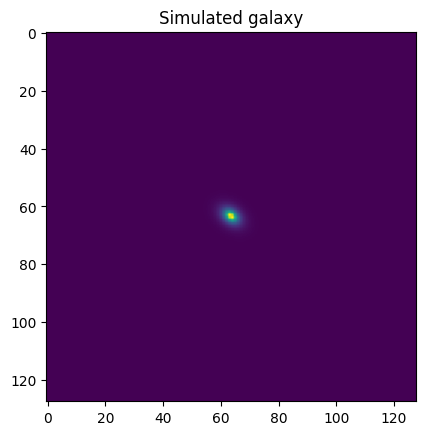

In [91]:
# Choose Index of Galaxy to test
ind = 1
gal_ex=1*dataset["gal_arrs"][ind]
truth=dataset['ellipticity'][ind]
flux=dataset['flux'][ind]

# Plot galaxy
plt.imshow(gal_ex)
plt.title("Simulated galaxy")
plt.show()

obs = make_data(gal_ex)

# ngmix paramters
rng = np.random.RandomState(2024)
prior = get_prior(rng=rng, scale=0.05, gal_arr=gal_ex)
fitter = ngmix.fitting.Fitter(model="exp", prior=prior)

In [92]:
# Define the correct guesser and runner for the problem
guesser = ngmix.guessers.TFluxAndPriorGuesser(
    rng=rng, T=np.mean(size_all), prior=prior, flux=np.mean(flux_all)
)

runner = ngmix.runners.Runner(
    fitter=fitter,
    guesser=guesser,
    ntry=10,
)

# Bootstrap the process
boot = ngmix.bootstrap.Bootstrapper(
    runner=runner,
)

res = boot.go(obs)
print()
print(f"true flux: {flux:03f}, meas g1: {res['flux']:03f} +/- {res['flux_err']*3:03f} (99.7%% conf)")
print(f"true g1: {truth[0]:03f}, meas g1: {res['g'][0]:03f} +/- {res['g_err'][0]*3:03f} (99.7%% conf)")
print(f"true g2: {truth[1]:03f}, meas g2: {res['g'][1]:03f} +/- {res['g_err'][1]*3:03f} (99.7%% conf)")


true flux: 0.000716, meas g1: 0.000705 +/- 0.000004 (99.7%% conf)
true g1: 0.048123, meas g1: 0.000000 +/- 0.000700 (99.7%% conf)
true g2: 0.170707, meas g2: 0.000000 +/- 0.000774 (99.7%% conf)


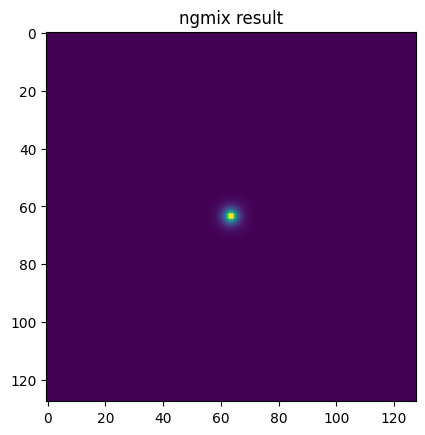

In [93]:
# Plot the galaxy recovered from ngmix
plt.imshow(res.make_image())
plt.title("ngmix result")
plt.show()